In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
csq = pd.read_csv('csq.gz', sep = " ", header= None)
samples= pd.read_csv('samples.gz', sep = " ", header= None)
csq = csq.values
samples = samples.values

In [4]:
m_true = np.array([1E4, 1E5, 2.5, 0.1])
m_0 = [10**(3.9), 10**(5.2), 1.5, 0.3]

nstep= 10000
csq_start = 123879376900.95654
param_length = np.shape(samples)[1]

In [5]:
#def mcmc(start_guess, samples, csq, csq_start, nstep):
def mcmc(samples, csq, nstep):

    #definig the chain
    chain = np.empty((nstep, np.shape(samples)[1]))
    chain[0, :] = samples[0, :]
     
    #defining the chi-square array
    chisq = np.zeros(nstep)
    #chisq[0] = chisq_start
    chisq[0] = csq[0]

    #defining the acceptance ratio
    acceptance_ratio = 0
            
    #the chain 
    for i in range(1, nstep):
        new_param = samples[i, :]
        new_chisq =  csq[i]      
        if new_chisq <= chisq[i-1]:
            acceptance_ratio = acceptance_ratio + 1
            chisq[i] = new_chisq
            chain[i, :] = new_param 
        else :
            betta = 1.5
            if np.random.rand(1)<betta*(np.exp(-0.5*(new_chisq-chisq[i-1]))):
                acceptance_ratio = acceptance_ratio + 1
                chisq[i] = new_chisq
                chain[i, :] = new_param
            else:
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]          
    return chain, chisq, acceptance_ratio/nstep

In [6]:
#params, cs, acceptance_ratio = mcmc(m_0, samples, csq, csq_start, nstep)
params, cs, acceptance_ratio = mcmc(samples, csq, nstep)

In [7]:
mcmc_param= np.empty(param_length)
for i in range(param_length):
    mcmc_param[i] = np.mean(params[:,i]) #array of best parameters  

In [8]:
mcmc_param

array([9.99999201e+03, 1.00001002e+05, 2.50004187e+00, 1.00000388e-01])

In [17]:
#error bars
print(np.std(params[:,0]))
print(np.std(params[:,1]))
print(np.std(params[:,2]))
print(np.std(params[:,3]))

0.06513363322361013
5.456975935743747
0.0002449151693338466
3.731946924487922e-06


In [10]:
print('True Parameters: ' + repr(m_true))
print('Starting Parameters: ' + repr(samples[0, :]))
print('MCMC Fitted Parameters: ' + repr(mcmc_param))
print("Chi-squared of original guess:"+ repr(cs[0]))
#print("Chi-squared of MCMC result:"+ repr(2996.786984538737))
print("acceptance_ratio for %d Steps: " %nstep + repr(acceptance_ratio*100) +"%")

True Parameters: array([1.0e+04, 1.0e+05, 2.5e+00, 1.0e-01])
Starting Parameters: array([1.00000639e+04, 9.99977386e+04, 2.49984165e+00, 9.99952406e-02])
MCMC Fitted Parameters: array([9.99999201e+03, 1.00001002e+05, 2.50004187e+00, 1.00000388e-01])
Chi-squared of original guess:41.3434186203965
acceptance_ratio for 10000 Steps: 18.95%


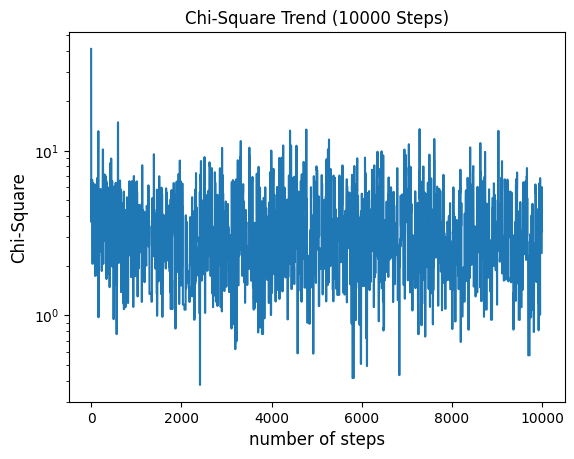

In [11]:
plt.semilogy(cs)
plt.xlabel('number of steps', fontsize=12)
plt.title ('Chi-Square Trend (%d Steps)'%nstep, fontsize=12)
plt.ylabel('Chi-Square', fontsize=12)
plt.savefig('csq_trend.png')
plt.show()

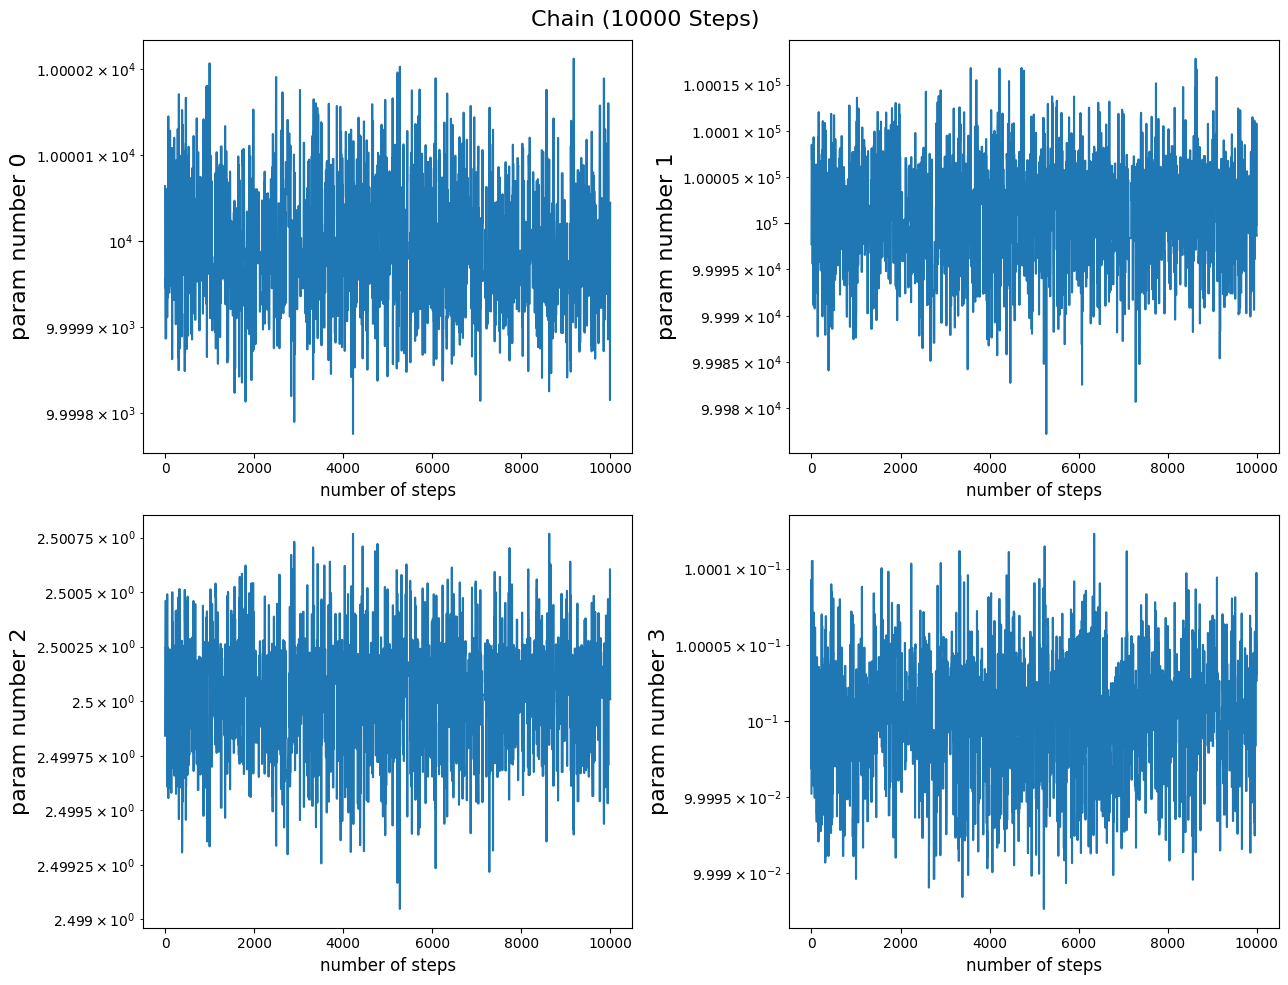

In [12]:
fig3, ax_list = plt.subplots(2, 2, figsize=(13,10))
fig3.suptitle('Chain (%d Steps)'%nstep, fontsize=16)
ax_list[0, 0].semilogy(params[:,0])
#ax_list[0, 0].set_ylim(bottom=9.999E3, top=1.0001E4)
ax_list[0, 0].set_ylabel('param number 0', fontsize=16)
ax_list[0, 0].set_xlabel('number of steps', fontsize=12)

ax_list[0, 1].semilogy(params[:,1])
#ax_list[0, 1].set_ylim(bottom= 9.997E4, top=1.001E5)
ax_list[0, 1].set_ylabel('param number 1', fontsize=16)
ax_list[0, 1].set_xlabel('number of steps', fontsize=12)

ax_list[1, 0].semilogy(params[:,2])
#ax_list[1, 0].set_ylim(bottom=1.699, top=1.701)
ax_list[1, 0].set_ylabel('param number 2', fontsize=16)
ax_list[1, 0].set_xlabel('number of steps', fontsize=12)

ax_list[1, 1].semilogy(params[:,3])
#ax_list[1, 1].set_ylim(bottom=9.99E-2, top= 1.001E-1)
ax_list[1, 1].set_ylabel('param number 3', fontsize=16)
ax_list[1, 1].set_xlabel('number of steps', fontsize=12)
plt.tight_layout()
plt.savefig('chain.png')
plt.show()


In [13]:
#Fourier Transform
ps = np.zeros((nstep, param_length))
for i in range(param_length):
    ps[:, i] = np.abs(np.fft.fft(params[:, i]))**2
    
freqs = np.fft.rfftfreq(nstep)
idx = np.argsort(freqs)

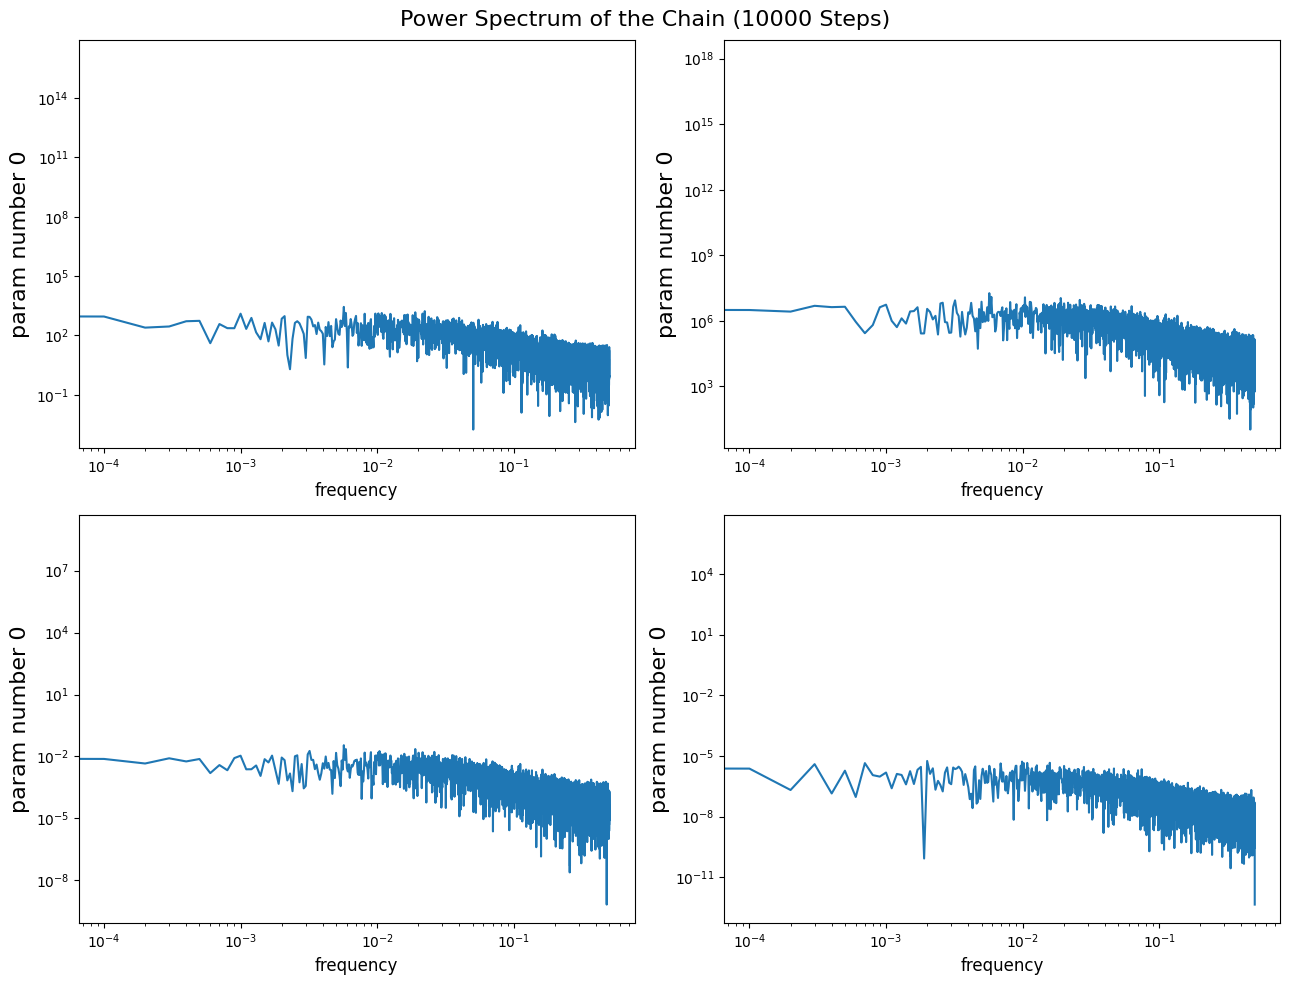

In [14]:
fig4, ax_list = plt.subplots(2, 2, figsize=(13,10))
fig4.suptitle('Power Spectrum of the Chain (%d Steps)'%nstep, fontsize=16)

ax_list[0, 0].loglog(freqs[idx], ps[idx, 0])
ax_list[0, 0].set_ylabel('param number 0', fontsize=16)
ax_list[0, 0].set_xlabel('frequency', fontsize=12)
#ax_list[0, 0].set_ylim(4E6, 4.5E6)

ax_list[0, 1].loglog(freqs[idx], ps[idx, 1])
ax_list[0, 1].set_ylabel('param number 0', fontsize=16)
ax_list[0, 1].set_xlabel('frequency', fontsize=12)
#ax_list[0, 1].set_ylim(3E9, 4E9)

ax_list[1, 0].loglog(freqs[idx], ps[idx, 2])
ax_list[1, 0].set_ylabel('param number 0', fontsize=16)
ax_list[1, 0].set_xlabel('frequency', fontsize=12)
#ax_list[1, 0].set_ylim(top = 1E0)

ax_list[1, 1].loglog(freqs[idx], ps[idx, 3])
ax_list[1, 1].set_ylabel('param number 0', fontsize=16)
ax_list[1, 1].set_xlabel('frequency', fontsize=12)
#ax_list[1, 1].set_ylim(3.7E-2,  4.5E-2)

plt.tight_layout()
plt.savefig('power_spectrum.png')
plt.show()


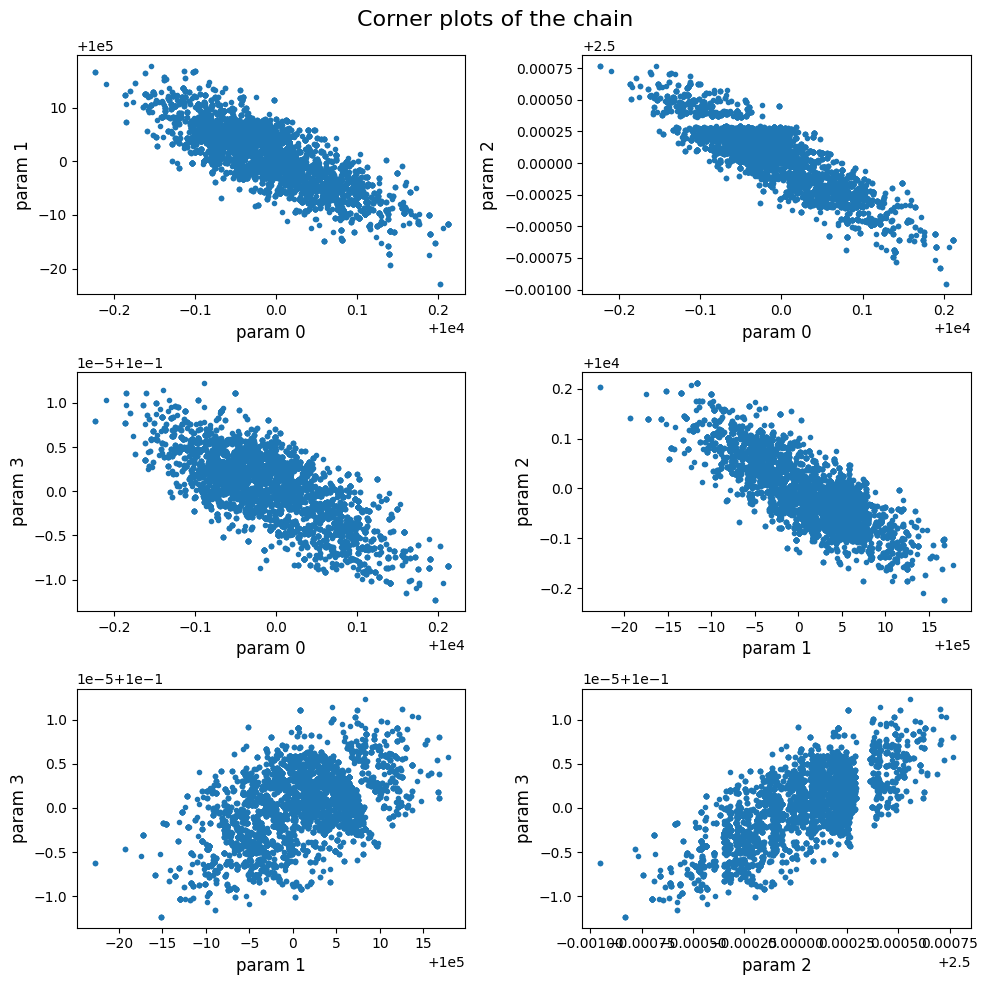

In [15]:
params_cut = params[1000:, :]
#params_cut = np.copy(params)
fig5, ax_list = plt.subplots(3, 2, figsize=(10,10))
fig5.suptitle('Corner plots of the chain', fontsize=16)

ax_list[0, 0].plot(params_cut[:, 0], params_cut[:, 1], linestyle = "", marker=".")
ax_list[0, 0].set_ylabel('param 1', fontsize=12)
ax_list[0, 0].set_xlabel('param 0', fontsize=12)

ax_list[0, 1].plot(params_cut[:, 0], params_cut[:, 2], linestyle = "", marker=".")
ax_list[0, 1].set_ylabel('param 2', fontsize=12)
ax_list[0, 1].set_xlabel('param 0', fontsize=12)
    
ax_list[1, 0].plot(params_cut[:, 0], params_cut[:, 3], linestyle = "", marker=".")
ax_list[1, 0].set_ylabel('param 3', fontsize=12)
ax_list[1, 0].set_xlabel('param 0', fontsize=12)

ax_list[1, 1].plot(params_cut[:, 1], params_cut[:, 0], linestyle = "", marker=".")
ax_list[1, 1].set_ylabel('param 2', fontsize=12)
ax_list[1, 1].set_xlabel('param 1', fontsize=12)

ax_list[2, 0].plot(params_cut[:, 1], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 0].set_ylabel('param 3', fontsize=12)
ax_list[2, 0].set_xlabel('param 1', fontsize=12)

ax_list[2, 1].plot(params_cut[:, 2], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 1].set_ylabel('param 3', fontsize=12)
ax_list[2, 1].set_xlabel('param 2', fontsize=12)

plt.tight_layout()
plt.savefig('corner_plots.png')
plt.show()